In [7]:
options(repr.matrix.max.cols=10, repr.matrix.max.rows=10)
options(repr.plot.width=22, repr.plot.height=22)
#setwd('~peter/fstats_tutorial')
suppressPackageStartupMessages({
    library(admixtools)
    library(tidyverse)
    source("/home/peter/fstats_tutorial/scripts/analysis.R")
})

# 0. Resources
- [`Admixtools`](https://github.com/DReichLab/AdmixTools)
- [`Admixtools 2`](https://github.com/uqrmaie1/admixtools)
- [`admixr`](https://github.com/bodkan/admixr)
- [Patterson et al. (2012)](http://www.genetics.org/content/192/3/1065)
- [Bhatia et al. (2013)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3759727/)
- [Peter (2016)](http://www.genetics.org/content/202/4/1485)
- [Petr et al. (2019)](https://academic.oup.com/bioinformatics/advance-article/doi/10.1093/bioinformatics/btz030/5298728)


# 1.  Setting up
To get your own copy of this tutorial, you can copy it on the server from my folder:

```bash
cp -r  ~peter/fstats_tutorial/ .
```

If you work in jupyter, there is no need to do that and you can access it directly from my folder. 

We will use the `R`-package `admixtools` for computation. This package is a fast implementation of $F$-statistics that works well if there is little missing data. It allows for precomputation of statistics, which saves us a lot of time. For this tutorial, I already prepared the data; but it can easily be regenerated using the following lines of code.

In [ ]:
#admixtools::extract_f2('data/world/worldfoci2', outdir='fdata/worldfoci2', blgsize = 0.05)
#admixtools::extract_f2('data/world/ancient', outdir='fdata/ancient', blgsize = 0.05)
#admixtools::extract_f2('data/europe/westeurasian1', outdir='fdata/westeurasia1', blgsize = 0.05)
#admixtools::extract_f2('data/europe/westeurasian2', outdir='fdata/westeurasia2', blgsize = 0.05)

# 2. Data
For this tutorial, we will be using data from the ancient DNA compendium by David Reich's lab,  that can be downloaded from https://reich.hms.harvard.edu/allen-ancient-dna-resource-aadr-downloadable-genotypes-present-day-and-ancient-dna-data. This data has an unique ascertainment
scheme, so throughout we need to keep ascertainment bias in mind. 

In order to save time, I subset the data and pre-computed F2-statistics that we will be using throughout. We will be using two distinct data sets; one focused on Western Eurasian diversity (`europe`), one representing global human diversity (`world`), and one designed to investigate archaic ancestry (`ancient`):

In [1]:
list.files("/home/peter/fstats_tutorial/data/europe/");
list.files("/home/peter/fstats_tutorial/data/world/");
list.files("/home/peter/fstats_tutorial/data/ancient/");

[1] "europe.1.frq"          "europe.1.frq.strat"    "europe.1.log"         
 [4] "europe.fam"            "europe.geno"           "europe.ind"           
 [7] "europe.log"            "europe.plinklist"      "europe.pop_geo"       
[10] "europe.poplist"        "europe.snp"            "westeurasian1.geno"   
[13] "westeurasian1.ind"     "westeurasian1.snp"     "westeurasian2.geno"   
[16] "westeurasian2.ind"     "westeurasian2.par"     "westeurasian2.poplist"
[19] "westeurasian2.snp"

[1] "ancient.geno"      "ancient.ind"       "ancient.par"      
 [4] "ancient.poplist"   "ancient.snp"       "course.R"         
 [7] "f2"                "world.1.frq"       "world.1.frq.strat"
[10] "world.1.log"       "world.fam"         "world.frq"        
[13] "world.frq.strat"   "world.geno"        "world.ind"        
[16] "world.log"         "world.plinklist"   "world.poplist"    
[19] "world.snp"         "world.traw"        "worldfoci2.geno"  
[22] "worldfoci2.ind"    "worldfoci2.snp"

[1] "ancient.1.frq"       "ancient.1.frq.strat" "ancient.1.log"      
 [4] "ancient.fam"         "ancient.geno"        "ancient.ind"        
 [7] "ancient.log"         "ancient.plinklist"   "ancient.poplist"    
[10] "ancient.snp"         "ancient.traw"        "f2"

The `.ind` and `.snp`-files are text files with information about each individual and each SNP respectively. The `.geno`-file is a compressed file with the actuall genotype information. See [this file](https://github.com/DReichLab/AdmixTools/blob/master/convertf/README) for detailed information on the file format. The text files can be read into R using the standard i/o functions:

In [2]:
ind_world <- readr::read_table("/home/peter/fstats_tutorial/data/world/worldfoci2.ind", col_names=c("ind", "sex", "pop"), col_types='ccc')
ind_eu <- readr::read_table("/home/peter/fstats_tutorial/data/europe//westeurasian1.ind", col_names=c("ind", "sex", "pop"), col_types='ccc')
ind_ancient <- readr::read_table("/home/peter/fstats_tutorial/data/world/ancient.ind", col_names=c("ind", "sex", "pop"), col_types='ccc')

ind_eu

ind,sex,pop
<chr>,<chr>,<chr>
Adg-185,F,Adygei
Adg-192,M,Adygei
Adg-194,M,Adygei
Adg-222,M,Adygei
Adg-224,M,Adygei
Adg-226,F,Adygei
Adg-227,F,Adygei
Adg-238,M,Adygei
GEO-002,M,Georgian


**Question 1:** How many individuals and populations are there in these data sets?

In [4]:
nrow(ind_world)
length(unique(ind_world$pop))

[1] 638

[1] 33

### 2.1 calculating FST
In general, there is a very large number of different estimators of $F_{ST}$ (see [this paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3759727/) for details). Here, we will use Hudson's estimator which is relatively simple and robust. We can calculate all pairwise $F_{ST}$-values using the `fst` function of `admixtools`:

In [8]:
f2s_eu = read_f2("/home/peter/fstats_tutorial/fdata/westeurasia1") #load precomputed data
f2s_world = read_f2("/home/peter/fstats_tutorial/fdata/worldfoci2") #load precomputed data

pwfst1=fst(f2s_eu)
pwfst2=fst(f2s_world)

In [ ]:
pwfst2

These tables give us the pairwise $F_{ST}$-values between all pairs of populations. Are these values big or small? This is quite difficult to answer without context, as it will depend on the type of data you are analyzing, the amount of data and the scope of your study. To provide context, one often looks at a matrix of $F_{ST}$-values, which can be visualized using a heatmap. We are going to use the function `fst_plot` that I wrote for this purpose. It will transform above data frames into a matrix, and then generate a heatmap using the `heatmap.2`-function. In case you are interested in details, you can see the function definition by just typing `fst_plot` on the command line.

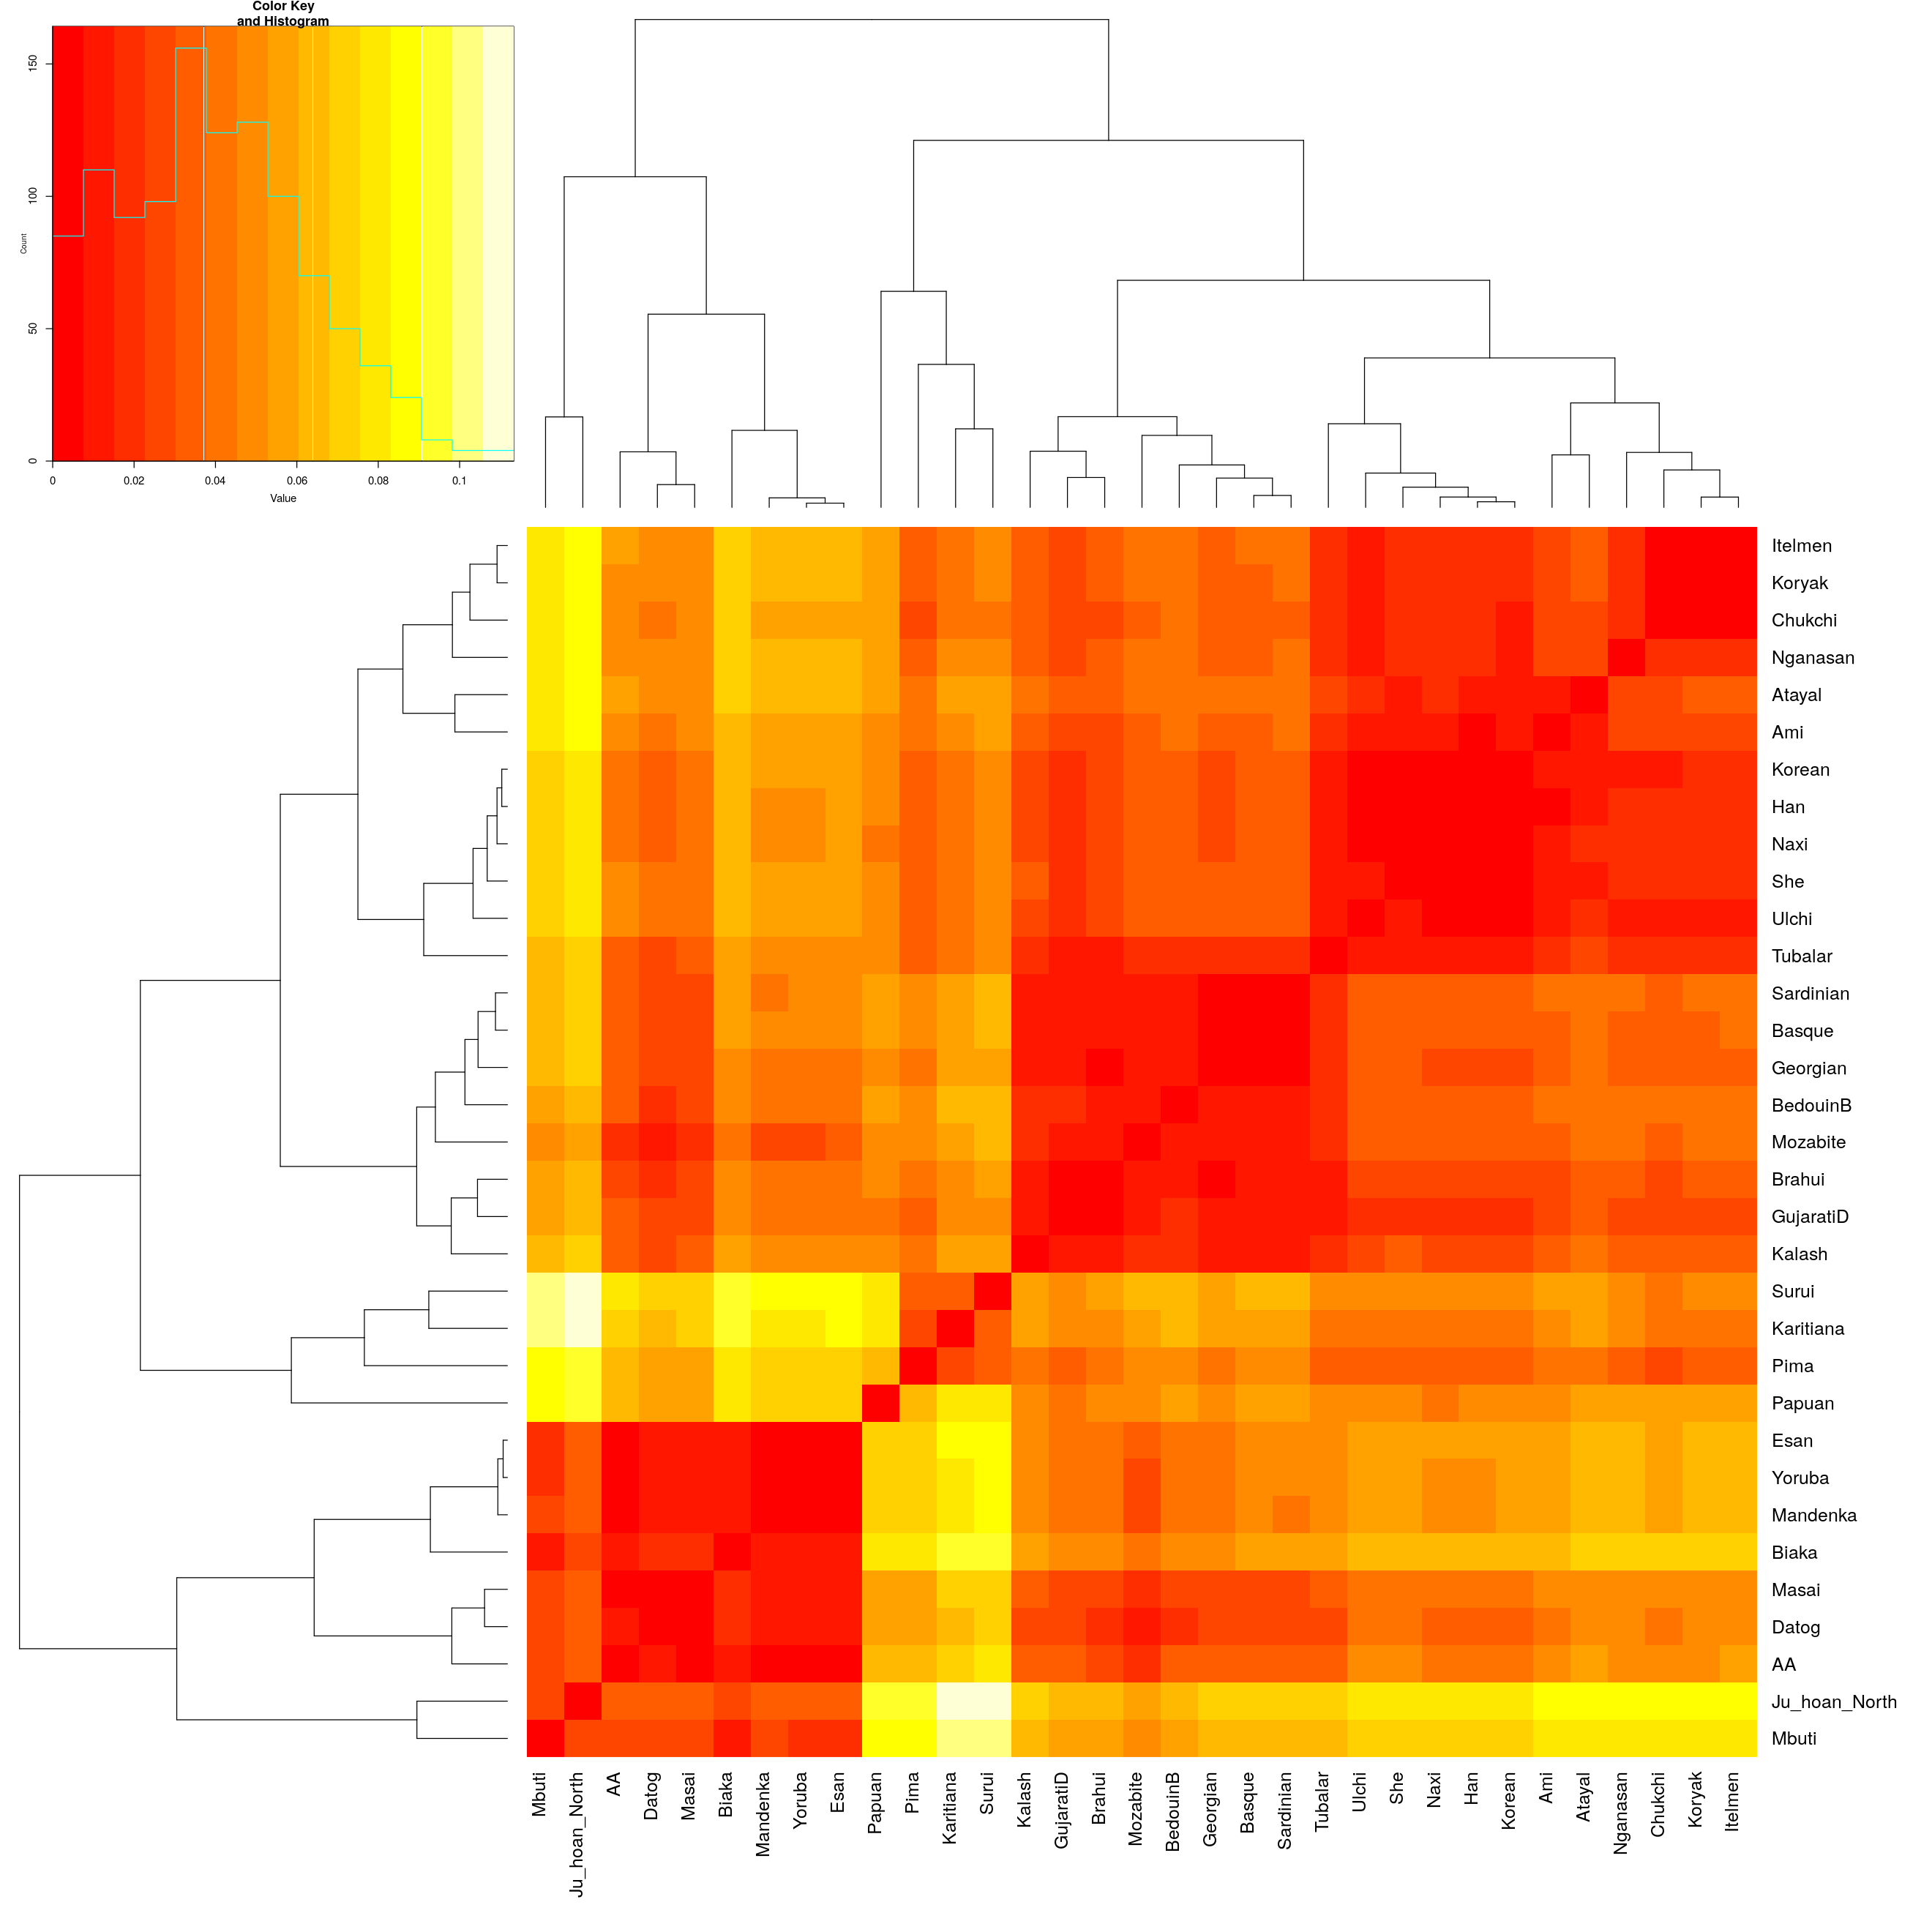

In [12]:
fst_plot(f2s_world, cex.label=1.5)

**Task 1**: Create a $F_{ST}$-plot for the world data set using the same function as above. How do the results compare between the two data sets?

A pairwise matrix of $F_{ST}$ or $F_2$-values yields a basic overview of a data set from a structured population. It is the basis for many follow-up applications, including building trees and admixture graphs (tomorrow) or computing a PCA (yesterday, my talk on Friday).

## 3. Admixture-F3
We will use the `world`-dataset that contains a small set of samples from all
continents. We'll hypothesize that African Americans (`AA`) are an admixed group resulting from the mixture of two populations. We'll assume that one source population are Yoruba from Nigeria, and 

1. aim to test our hypothesis that African Americans are admixed
2. make some inference what the other source population may be

In [13]:
f3_aa = f3(f2s_world, pop1='AA', pop2='Yoruba', pop3=unique(ind_world$pop)) %>% arrange(est)
f3_aa

pop1,pop2,pop3,est,se,z,p
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
AA,Yoruba,Basque,-0.004777214,0.0001110123,-43.03319,0
AA,Yoruba,Sardinian,-0.004585963,0.0001110581,-41.29336,0
AA,Yoruba,Georgian,-0.004319089,0.0001057450,-40.84436,0
AA,Yoruba,Kalash,-0.004086874,0.0001085978,-37.63311,0
AA,Yoruba,Brahui,-0.003913767,0.0000985930,-39.69619,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮
AA,Yoruba,Mbuti,0.002164048,8.005551e-05,27.03184,6.245131e-161
AA,Yoruba,Biaka,0.002384887,7.849669e-05,30.38201,9.494679e-203
AA,Yoruba,Mandenka,0.002521384,7.111747e-05,35.45380,2.534922e-275


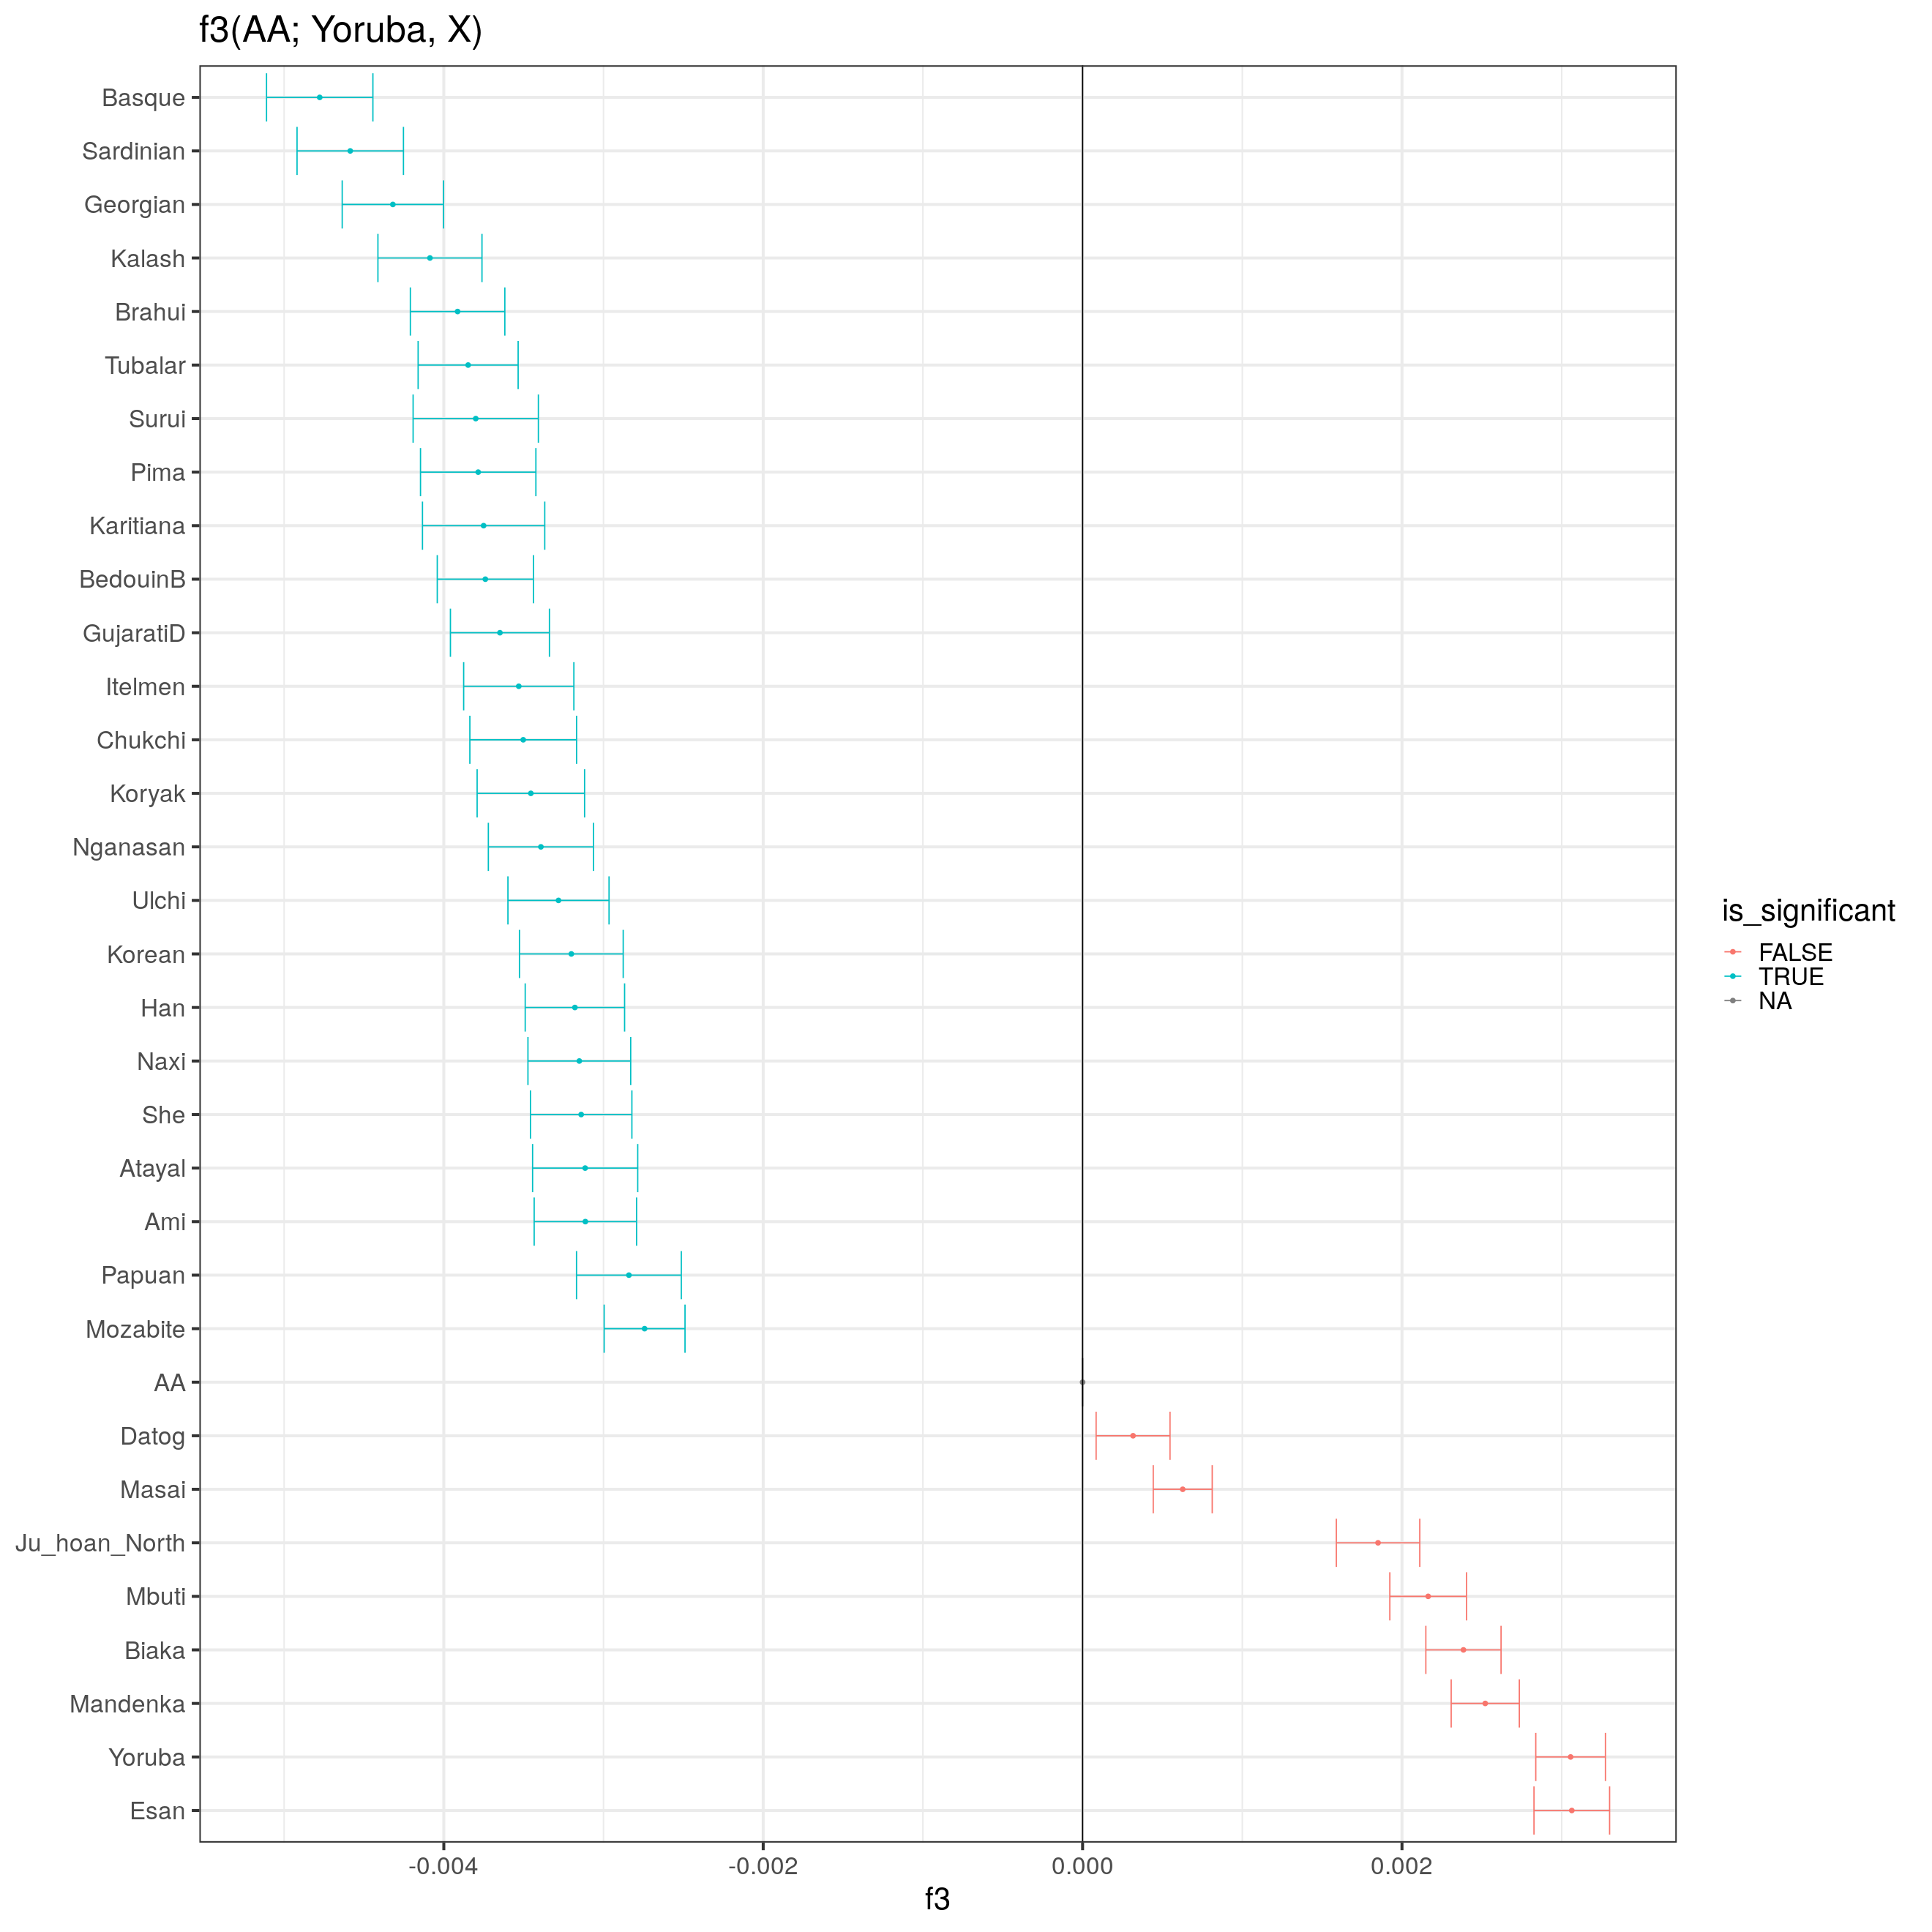

In [14]:
f3_aa %>% 
    mutate(is_significant=z < -3, pop3=fct_reorder(pop3, -est)) %>% 
    ggplot(aes(x=pop3, y=est, ymin=est-3*se, ymax = est+3*se, color=is_significant)) +
    geom_point() + geom_errorbar() +geom_hline(yintercept = 0) + coord_flip() + theme_bw(25) +
    ggtitle("f3(AA; Yoruba, X)") + xlab(NULL) + ylab("f3")

**Question 2**: 
- Are any $F_3$-statistics negative? 
- Are they significant? (|Z| > 3?)?
- Which pairs of populations do these correspond to? 
- What could this mean about the population genetic history of the African Americans?

## 4. Outgroup-F3
Next, we can compute outgroup-F3 stats in a very similar fashion. We use outgroup-$F_3$-statistics of the form $F_3(\text{Outgroup}; \text{Unknown}, X_i)$ to find the population $X_i$ that is closest to the unknown population. For the next task, we will calculate some outgroup-$F_3$-statistics. We'll use the Western Eurasian data, which I modified to add an Outgroup (`Mbuti`, a population from central Africa with minimal European ancestry). and an  additional population labelled as `Unknown`. 

Which population could they be most closely related to?

We can use a very similar approach as before:
 - pop1 will be the `Mbuti`-population
 - pop2 will be the `Unknown`-population
 - pop3 will be the list of all candidates

**Task 2:** Use `admixtools`  to 
1. load the `europe/worldfoci2`-data set into memory using the `admixtools::read_f2`-function
2. read all populations present in that data into memory
3. calculate all outgroup-$F_3$-statistics
4. create a figure visualizing your results, adapting the figure from above

In [15]:
f2s= read_f2('fdata/westeurasia2')
pops = dimnames(f2s)[1][[1]]
pops

[1] "Abkhasian"          "Adygei"             "Albanian"          
 [4] "Armenian"           "Assyrian"           "Balkar"            
 [7] "Basque"             "BedouinA"           "BedouinB"          
[10] "Belarusian"         "Bulgarian"          "Canary_Islander"   
[13] "Chechen"            "Chuvash"            "Croatian"          
[16] "Cypriot"            "Czech"              "Druze"             
[19] "English"            "Estonian"           "Finnish"           
[22] "French"             "Georgian"           "Greek"             
[25] "Hungarian"          "Icelandic"          "Iranian"           
[28] "Italian_North"      "Italian_South"      "Jew_Ashkenazi"     
[31] "Jew_Georgian"       "Jew_Iranian"        "Jew_Iraqi"         
[34] "Jew_Libyan"         "Jew_Moroccan"       "Jew_Tunisian"      
[37] "Jew_Turkish"        "Jew_Yemenite"       "Jordanian"         
[40] "Kumyk"              "Lebanese"           "Lebanese_Christian"
[43] "Lebanese_Muslim"    "Lezgin"             "Lithuanian"        
[46] "Maltese"            "Mbuti"              "Mordovian"         
[49] "Norwegian"          "Orcadian"           "Ossetian"          
[52] "Palestinian"        "Romanian"           "Russian"           
[55] "Sardinian"          "Saudi"              "Scottish"          
[58] "Sicilian"           "Spanish"            "Spanish_North"     
[61] "Syrian"             "Turkish"            "Ukrainian"         
[64] "Unknown"

In [16]:
f3_res = f3(f2s, pop1='Mbuti', pop2='Unknown', pop3=pops)
f3_res

pop1,pop2,pop3,est,se,z,p
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Mbuti,Unknown,Abkhasian,0.06360018,0.0004665676,136.3150,0
Mbuti,Unknown,Adygei,0.06369154,0.0004546856,140.0782,0
Mbuti,Unknown,Albanian,0.06502310,0.0004733897,137.3564,0
Mbuti,Unknown,Armenian,0.06336399,0.0004661902,135.9187,0
Mbuti,Unknown,Assyrian,0.06279820,0.0004501390,139.5085,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Mbuti,Unknown,Spanish_North,0.06599470,0.0004926482,133.9591,0
Mbuti,Unknown,Syrian,0.06033563,0.0004637982,130.0903,0
Mbuti,Unknown,Turkish,0.06310582,0.0004587273,137.5672,0


In [17]:
viz_outgroup_f3 <- function(f3_res){
    f3_res %>% mutate(pop3=fct_reorder(pop3, est)) %>%  
    ggplot(aes(x=pop3, y=est, ymin=est-3*se, ymax = est+3*se)) +
    geom_point() + 
    geom_errorbar() +
    #geom_hline(yintercept = 0) + 
    coord_flip() + 
    theme_bw(25) +
    xlab(NULL) + ylab("f3")
    }

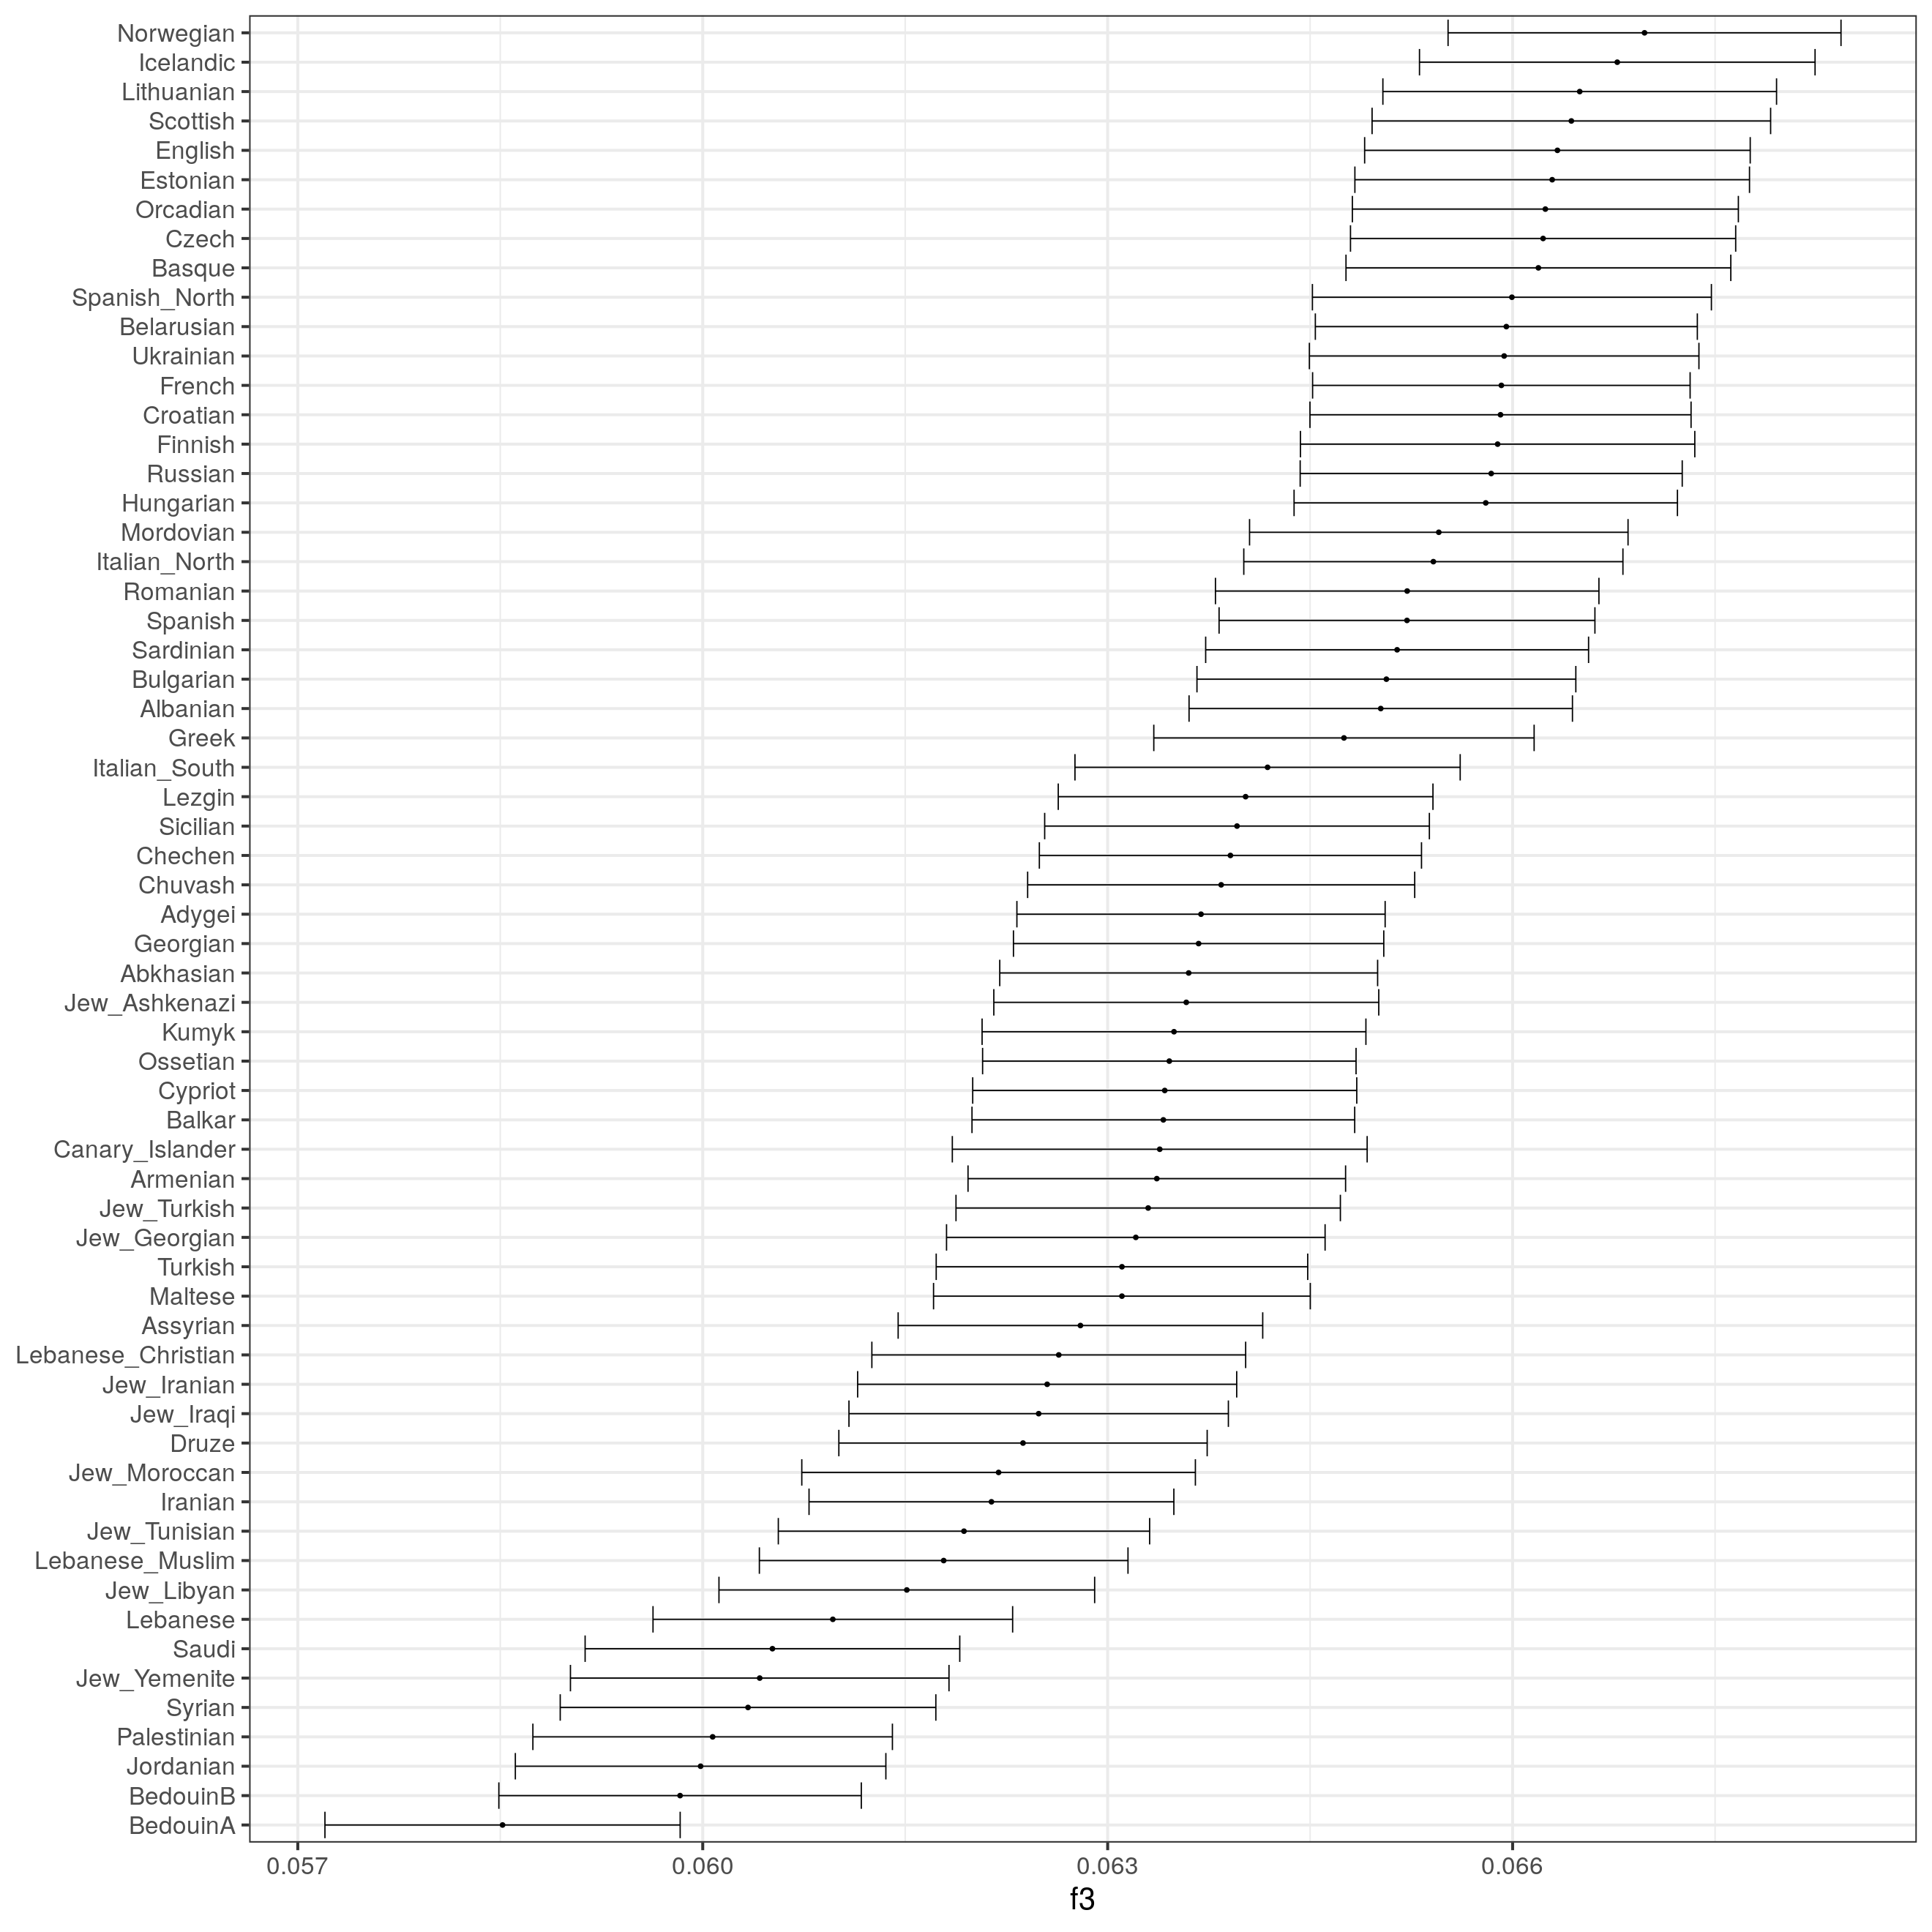

In [18]:
viz_outgroup_f3(f3_res%>% filter(!pop3 %in% c("Mbuti", "Unknown")))

## 5. f4/D-statistics
next, we can test for admixture in the past history of humans by lookin for an excess of ABBA or an excess of BABA sites in a 4-population tree.
For this purpose, we use the ancient dataset, which contains a subset of the Chimpanzee, three Neandertals and a small number of modern Human population samples.
To calculate $F_4$-stats is very similar to calculating $F_3$: instead of `admixtools::f3` we use `admixtools::f4`:

**Task 3**: Use admixr (or if you really prefer, qpDstat manually) to
 - calculate all f4-statistics of the form $D(\text{African}, \text{Non-African}, \text{Neandertals}, \text{Primate})$ (the African populations are Mbuti and Yoruba; the Non-Africans are French, Han and Papuan)
 - create a figure visualizing your results (you may use the function below)

**Question 3**: Are any of the statistics significant? In what direction? Is this consistent with what you might expect? 

In [19]:
viz_d <- function(d_res) 
    d_res %>%
    mutate(sig=as.factor(abs(z)>3)) %>%
    ggplot(aes(x=pop1, y=est, ymin=est-3*se, ymax=est+3*se, color=pop3,group=pop3)) + 
    geom_point(position=position_dodge(0.8)) + 
    geom_errorbar(position=position_dodge(0.8)) +
    geom_hline(yintercept=0) +
    theme_bw(25) +
    facet_grid(pop2~.)

In [20]:
ancient = read_f2('/home/peter/fstats_tutorial/fdata/ancient')
pops = dimnames(ancient)[1][[1]]
pops

[1] "Altai_Neanderthal.DG"   "Denisova.DG"            "French"                
[4] "Han"                    "Mbuti"                  "Papuan"                
[7] "Primate_Chimp"          "Vindija_Neanderthal.DG" "Yoruba"

In [23]:
d_res = f4(ancient, 
           pop1=c('Papuan', 'Han', 'French'),
           pop2=c('Yoruba', 'Mbuti'),
           pop3=c('Denisova.DG', 'Altai_Neanderthal.DG', 'Vindija_Neanderthal.DG'),
           pop4='Primate_Chimp', f4mode=T)
d_res

pop1,pop2,pop3,pop4,est,se,z,p
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Papuan,Yoruba,Denisova.DG,Primate_Chimp,0.002257982,0.0002549580,8.856288,8.272271e-19
Papuan,Yoruba,Altai_Neanderthal.DG,Primate_Chimp,0.002363205,0.0003016562,7.834101,4.722082e-15
Papuan,Yoruba,Vindija_Neanderthal.DG,Primate_Chimp,0.002543871,0.0003123454,8.144419,3.811073e-16
Papuan,Mbuti,Denisova.DG,Primate_Chimp,0.001945455,0.0002817148,6.905763,4.993419e-12
Papuan,Mbuti,Altai_Neanderthal.DG,Primate_Chimp,0.002111294,0.0003347881,6.306359,2.856756e-10
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
French,Yoruba,Altai_Neanderthal.DG,Primate_Chimp,0.0015913965,0.0001973251,8.064847,7.332784e-16
French,Yoruba,Vindija_Neanderthal.DG,Primate_Chimp,0.0017540568,0.0002028303,8.647904,5.245398e-18
French,Mbuti,Denisova.DG,Primate_Chimp,-0.0003202461,0.0002185635,-1.465232,1.428578e-01


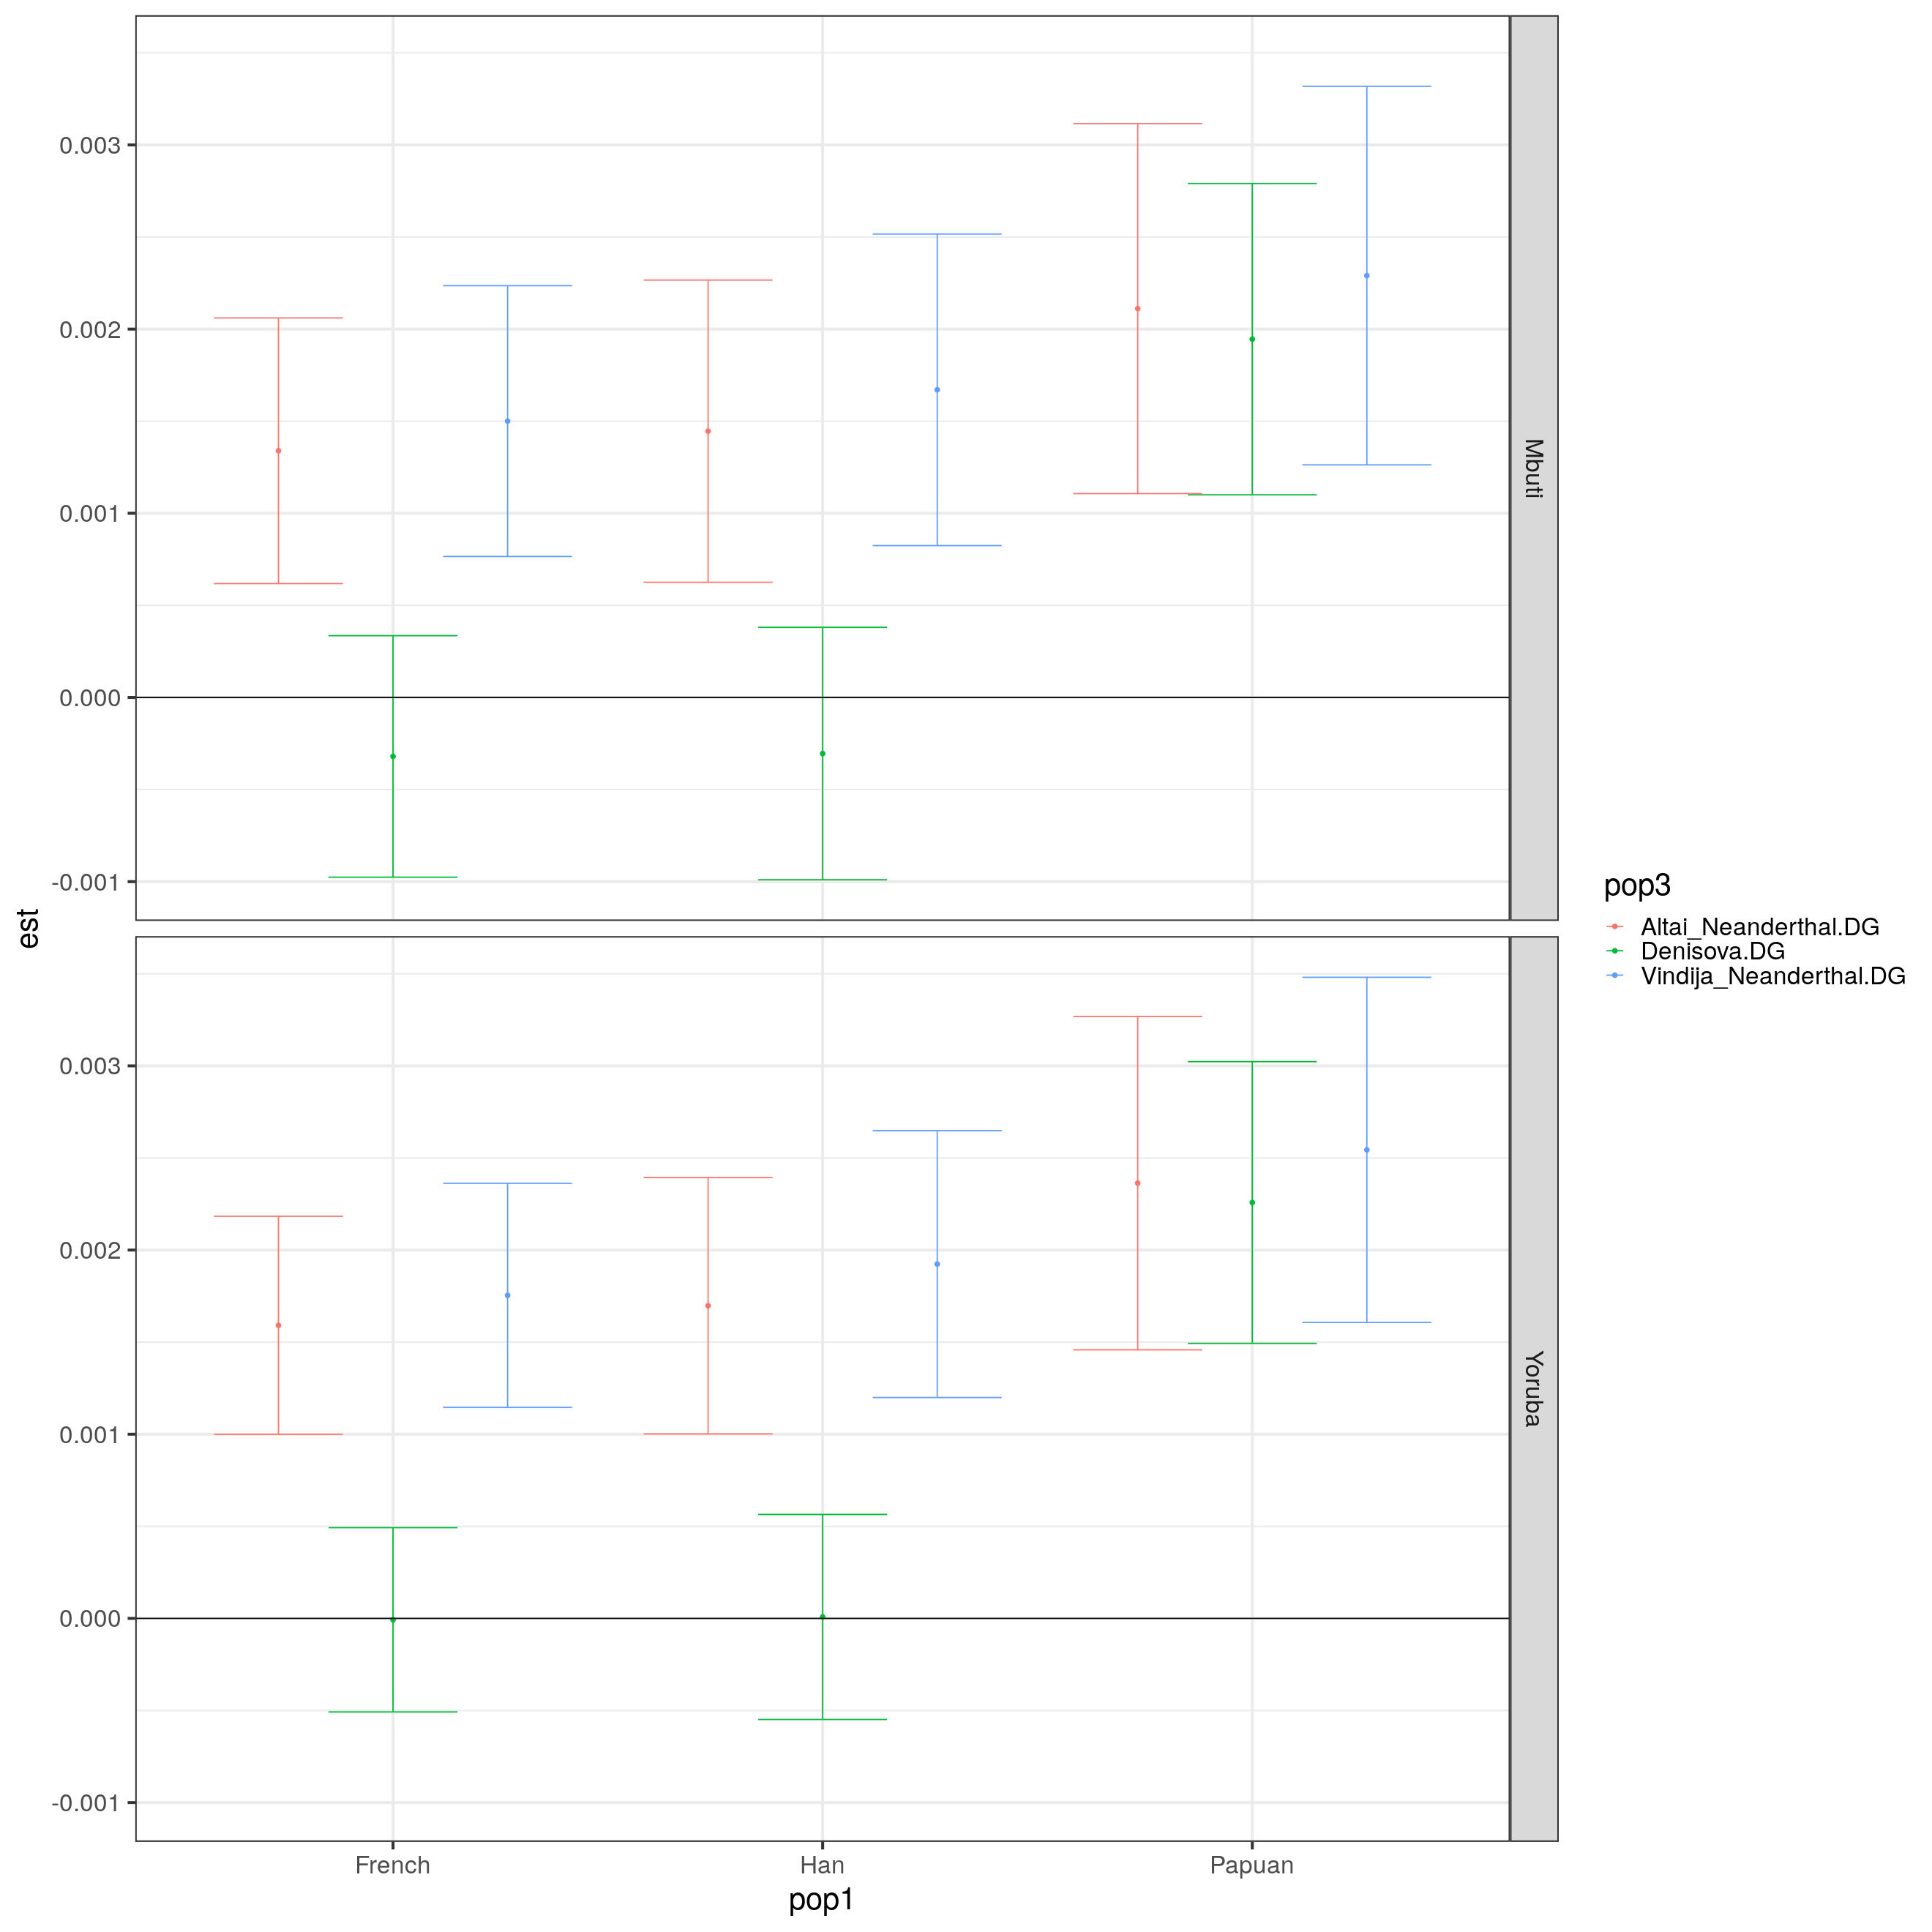

In [24]:
d_res %>% viz_d

## 6. estimating admixture proportions
The final task in the F-statistics framework will be to calculate admixture proportions using the $F_4$-ratio. 

For this purpose, we will use a data set that aims at estimating the proportion of Neandertal ancestry in modern humanms, based on the analysis by [Petr et al. 2019](https://www.pnas.org/content/116/5/1639), who used the assumption that all Neanderthal ancestry is closer to a Neandertal from Vindija Cave (in Croatia) than a Neandertal genome from Denisova cave (Altai, Russia). 

We assume that the populations are related like this:
 <img src="F4.large.jpg" alt="F4-ratio" style="width: 400px;"/>
 
 and estimate the admixture proportion $\alpha$ as
 $$\alpha = \frac{f_4(A, O; X, C)}{f_4(A, O; B, C)}$$
   

**Task 3**: Use the `qpf4ratio`-function in `admixtools` to use the ancient data (that we used for the $D$-stats exercise to estimate the Neandertal ancestry in French, Han and Papuans.

- have a look at `?qpf4ratio` to figure out the arguments this function expects
- which population is in which position of the arguments? Construct a vector `v` or data frame that matches this order
- run the f4-ratio-estimation using `qpf4ratio(ancient, v)
- do the archaic ancestries differ between the three populations?

In [ ]:
df = rbind(c('Altai_Neanderthal.DG', 'Primate_Chimp', 'French', 'Yoruba', 'Vindija_Neanderthal.DG'),
           c('Altai_Neanderthal.DG', 'Primate_Chimp', 'Han', 'Yoruba', 'Vindija_Neanderthal.DG'),
           c('Altai_Neanderthal.DG', 'Primate_Chimp', 'Papuan', 'Yoruba', 'Vindija_Neanderthal.DG')
          )
f4r_res = qpf4ratio(ancient, 
           df, verbose=T)
f4r_res